In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from scipy.signal import find_peaks, savgol_filter
from scipy.special import wofz
import scipy.stats
from scipy.optimize import curve_fit
from boxsers.preprocessing import savgol_smoothing, als_baseline_cor, spectral_normalization, spectral_cut, rubberband_baseline_cor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.decomposition import PCA, FactorAnalysis, NMF

In [3]:
# import matplotlib as mpl
# mpl.use('pgf')
# mpl.rcParams.update({
#     "pgf.texsystem": "pdflatex",  # Use pdflatex for rendering
#     'font.family': 'serif',       # Use serif font family
#     'text.usetex': True,          # Use LaTeX for text rendering
#     'pgf.rcfonts': False,         # Don't setup fonts from rc params
#     'pgf.preamble': r'\usepackage{amsmath,amsfonts,amssymb}\usepackage[T2A,T1]{fontenc}\usepackage[utf8]{inputenc}\usepackage[ukrainian]{babel}',  # Use Ukrainian Cyrillic font
#     'font.size': 10               # Set font size
# })

In [4]:
import os

In [5]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [6]:
import sys
sys.path.append('../tools')
from analysis import *
# from curve_fitting import *

In [7]:
# pd.options.display.float_format = '{:.5f}'.format

<Axes: >

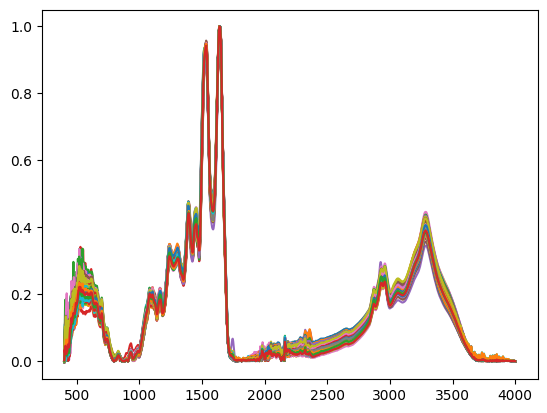

In [8]:
domain = pd.read_csv("../data/domain.csv").to_numpy().reshape(1, -1)[0]
df = pd.read_csv('../data/dataset.csv')
max_abs = df.drop(columns=['HbA1c', 'years']).apply(lambda row: True if row.max() > 0.30 else False, axis=1)
df = df[max_abs]

df = df.drop(columns='years')

X_raw = df.drop(columns='HbA1c')
X_raw.columns = np.ravel(domain)
#X = X.apply(lambda row: row / row.max(), axis=1)
X = X_raw.T.apply(lambda col: np.ravel(rubberband_baseline_cor(col))).T
X = X.T.apply(lambda col: savgol_filter(col, window_length=5, polyorder=1)).T
X = X.apply(lambda row: row / row.max(), axis=1)
#X = X_raw.apply(lambda row: row / np.linalg.norm(row), axis=1)

y = df['HbA1c']
X.T.plot(legend=False)

In [9]:
def combined_pseudo_voigt(x, *params):
    """ 
    Voigt profile approximation by linear combination of
    Lorenzian and Gaussian distributinos.
    mu, A, A0, FWHM, eta
    """
    N = len(params) // 5
    result = np.zeros_like(x)
    for i in range(N):
        mu, gamma_gaussian, gamma_lorentzian, amplitude, eta = params[i*5:(i+1)*5]
        
        a_G = (2 / gamma_gaussian) * np.sqrt(np.log(2) / np.pi)
        b_G = (4 * np.log(2)) / (gamma_gaussian**2)
        gaussian_term = a_G * np.exp(-b_G * (x - mu)**2)
        
        lorentzian_term = (1 / np.pi) * ( (gamma_lorentzian / 2) / ( (x - mu)**2 + (gamma_lorentzian / 2)**2) ) 
        
        result += amplitude * (eta * gaussian_term + (1 - eta) * lorentzian_term)

    return result

In [10]:
def corr_plot(X, y):
    r, p_val = pearsonr(X, y)
    
    model = LinearRegression()
    model.fit(X.reshape(-1, 1), y)
    
    x_range = np.linspace(min(X), max(X))
    predicted = model.predict(x_range.reshape(-1, 1))
    
    if p_val < 0.00001:
        text = f"$R = {r:.3f}$\n$p < 0.00001$\n$y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}$"
    else:
        text = f"$R = {r:.3f}$\n$p = {p_val:.5f}$\n$y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}$"
        
    plt.scatter(X, y, facecolor='w', edgecolor='k')
    plt.plot(x_range, predicted, color='r', linewidth=1.5)
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")

    x_offset = (max(X) - min(X)) * 0.02
    y_offset = (max(y) - min(y)) * 0.02
    text_x = min(X)
    text_y = max(y)

    print(text)
    
    plt.text(text_x, text_y, text, verticalalignment='top')

In [11]:
def get_secondary_structure(areas_df):
    intermol_beta_sheet = areas_df['1611-1614'] + areas_df['1616-1619'] + areas_df['1622-1626']
    beta_sheet = areas_df['1627-1630'] + areas_df['1631-1634'] + areas_df['1635-1638'] + areas_df['1639-1641']
    random_coil = areas_df['1643-1646'] + areas_df['1646-1649']
    alpha_helix = areas_df['1650-1654'] + areas_df['1655-1657']
    beta_turn = (areas_df['1659-1663'] + areas_df['1665-1670'] + 
                 areas_df['1672-1675'] + areas_df['1678-1680'] + 
                 areas_df['1681-1685'] + areas_df['1686-1689'] +
                 areas_df['1693-1696'] + areas_df['1698-1700']
                )
    result = {
        "intermol beta sheet": intermol_beta_sheet,
        "beta sheet": beta_sheet,
        "random coil": random_coil,
        "alpha helix": alpha_helix,
        "beta turn": beta_turn, 
        "all beta": intermol_beta_sheet + beta_sheet + beta_turn
    }
    
    return pd.DataFrame(result)

In [12]:
def make_plot(x_values, params):
    """ Makes plot using parameters from pseudo voigt fitting """
    y_peaks = []
    
    plt.figure(figsize=(8, 5))
    
    for index, row in params.iterrows():
        y_pred = combined_pseudo_voigt(x_values, *row[['wavenumber', 'gamma_gauss', 'gamma_lorentz', 'amplitude', 'eta']])
        plt.plot(x_values, y_pred, color='k', linewidth=0.5, linestyle='--', alpha=0.8)
        y_peaks.append(y_pred)
    
    y_peaks = np.array(y_peaks)

    #plt.plot(x_values, y_values, color='r')
    plt.plot(x_values, y_peaks.sum(axis=0), color='k')
    plt.xlim([min(x_values), max(x_values)])
    #plt.ylim([0, 1.1])
    plt.xlabel("Хвильове число")

def make_plot_amide(x_values, params):
    """ Makes plot using parameters from pseudo voigt fitting """
    y_peaks = []
    added_labels = {}
    
    plt.figure(figsize=(6.5, 4))
    
    for index, row in params.iterrows():
        y_pred = combined_pseudo_voigt(x_values, *row[['wavenumber', 'gamma', 'amplitude', 'eta']], 0)
        peak = x_values[np.argmax(y_pred)]

        if 1610 < peak < 1627:
            color = 'blue'
            label = r'Intermolecular $\beta$-sheet'
        elif 1628 < peak < 1642:
            color = 'green'
            label = r'$\beta$-sheet'
        elif 1643 < peak < 1650:
            color = 'red'
            label = r'Random coil'
        elif 1650 < peak < 1659:
            color = 'orange'
            label = r'$\alpha$-helix and Gln side chain'
        elif 1659 < peak < 1700:
            color = 'purple'
            label = r'$\beta$-turn'
        else:
            color = 'black'
            label = None

        if label and label not in added_labels:
            plt.fill_between(x_values, y_pred, color=color, alpha=0.1, label=label)
            added_labels[label] = True
        else:
            plt.fill_between(x_values, y_pred, color=color, alpha=0.1)
        
        plt.plot(x_values, y_pred, color='k', linewidth=0.5, linestyle='--', alpha=0.8)
        y_peaks.append(y_pred)
    
    y_peaks = np.array(y_peaks)
    
    #plt.plot(x_values, y_values, color='b')
    plt.plot(x_values, y_peaks.sum(axis=0), color='k')
    plt.xlim([min(x_values), max(x_values)])
    plt.ylim([0, 1.1])
    plt.legend(fontsize=8)
    plt.xlabel("Хвильове число")

In [13]:
params = pd.read_csv("../data/fits/fit_1250_2750_w5_o3/101_pseudo_voigt_fit_5.0.csv")
params

,Unnamed: 0,peak_found,wavenumber,gamma_gauss,gamma_lorentz,amplitude,eta,FWHM,area
0,0,1012.462,1016.298833,0.009409,3.326937,0.022385,1.770336e-01,3.628645,0.000068
1,1,1028.854,1029.904887,3.523052,13.502384,0.387743,3.018050e-24,13.899859,0.001370
2,2,1047.657,1043.811723,3.149142,19.094914,0.767309,5.413297e-35,19.661823,0.002722
3,3,1050.067,1055.058781,3.405713,27.808548,1.841701,2.864599e-31,27.963000,0.006448
4,4,1082.370,1080.549209,1.454048,40.137047,7.050199,1.393330e-04,40.499000,0.024657
...,...,...,...,...,...,...,...,...,...
62,62,1687.436,1687.536887,8.914155,11.449980,2.231759,4.327654e-01,10.042423,0.008336
63,63,1694.668,1694.401911,6.395299,8.436444,1.147640,5.699281e-02,8.667466,0.004226
64,64,1699.007,1699.074630,5.515272,3.728537,0.177572,1.318187e-02,4.231861,0.000667
65,65,1703.828,1703.765970,17.628841,6.925869,0.508472,6.549747e-01,12.319627,0.001918


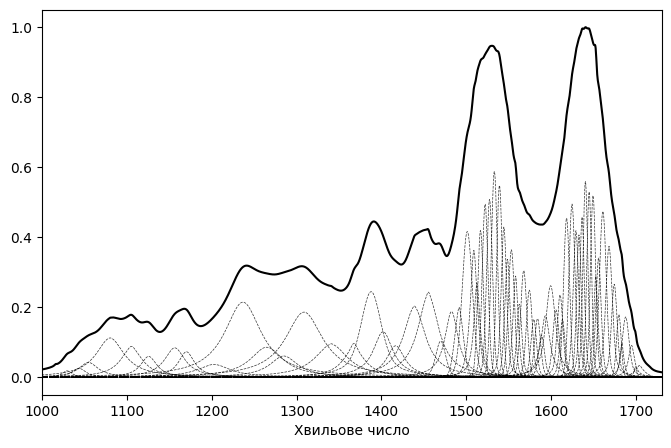

In [14]:
make_plot(np.linspace(1000, 1730, 2000), params)

In [15]:
columns = pd.read_csv("../data/peak_means")['0'].astype(np.int32)
columns

0     1012
1     1029
2     1047
3     1051
4     1080
      ... 
62    1687
63    1694
64    1699
65    1703
66    1717
Name: 0, Length: 67, dtype: int32

In [16]:
peaks = pd.read_csv("../data/peaks.csv")
peaks_mean = peaks.mean(axis=0).astype(np.int32)

In [17]:
amide_columns = peaks_mean.index[40:-2]
amide_columns

Index(['1581-1584', '1585-1587', '1588-1592', '1600-1603', '1604-1606',
       '1608-1610', '1611-1614', '1616-1619', '1622-1626', '1627-1630',
       '1631-1634', '1635-1638', '1639-1641', '1643-1646', '1646-1649',
       '1650-1654', '1655-1657', '1659-1663', '1665-1670', '1672-1675',
       '1678-1680', '1681-1685', '1686-1689', '1693-1696', '1698-1700'],
      dtype='object')

In [18]:
path = "../data/fits/fit_1250_2750_w5_o3_params/"
areas = []
fwhms = []
wavenumbers = []
amplitude = []
gamma_g = []
gamma_l = []
eta = []
hba1c = []
age = []

for file in os.listdir(path):
    filename = os.path.splitext(file)[0]
    
    hba1c_value = filename.split("_")[-2]
    age_value = filename.split("_")[-1]
    
    hba1c.append(float(hba1c_value))
    age.append(int(age_value))
    
    result = pd.read_csv(os.path.join(path, file)).iloc[:, 1:]
    
    areas.append(result['area'].to_numpy())
    fwhms.append(result['FWHM'].to_numpy())
    wavenumbers.append(result['wavenumber'].to_numpy())
    amplitude.append(result['amplitude'].to_numpy())

    gamma_g.append(result['gamma_gauss'].to_numpy())
    gamma_l.append(result['gamma_lorentz'].to_numpy())
    eta.append(result['eta'].to_numpy())


age = np.array(age)
hba1c = np.array(hba1c)

wavenumbers = pd.DataFrame(wavenumbers, columns=columns)
areas = pd.DataFrame(areas, columns=columns) * 100
fwhms = pd.DataFrame(fwhms, columns=columns)
amplitude = pd.DataFrame(amplitude, columns=columns)

In [19]:
areas['HbA1c'] = hba1c
areas.corr()['HbA1c'].abs().sort_values(ascending=False).head(10)

0
HbA1c    1.000000
1012     0.580320
1029     0.573563
1567     0.333985
1717     0.292248
1552     0.271089
1652     0.261997
1617     0.260609
1080     0.259332
1159     0.253918
Name: HbA1c, dtype: float64

$R = 0.580$
$p < 0.00001$
$y = 33.99308x + 4.94375$


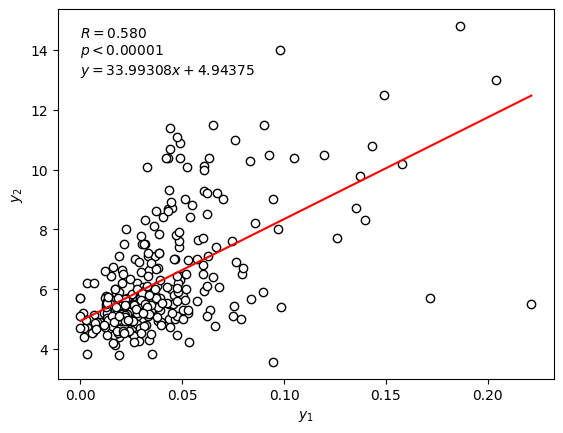

In [20]:
corr_plot(areas[1012].to_numpy(), hba1c)

In [21]:
fwhms['HbA1c'] = hba1c
fwhms.corr()['HbA1c'].abs().sort_values(ascending=False).head(10)

0
HbA1c    1.000000
1012     0.473146
1029     0.429905
1683     0.363449
1656     0.307674
1415     0.275208
1678     0.273113
1557     0.237318
1563     0.226031
1401     0.224605
Name: HbA1c, dtype: float64

In [22]:
delta = peaks_mean.to_numpy() - wavenumbers
delta['HbA1c'] = hba1c
delta.corr()['HbA1c'].abs().sort_values(ascending=False).head(20)

0
HbA1c    1.000000
1563     0.448476
1439     0.400782
1415     0.390813
1687     0.375915
1717     0.359837
1660     0.355565
1683     0.340460
1624     0.329071
1647     0.318935
1567     0.316827
1656     0.301381
1703     0.300284
1051     0.278955
1012     0.274987
1080     0.265645
1467     0.246201
1169     0.231518
1644     0.229939
1339     0.228187
Name: HbA1c, dtype: float64

In [23]:
amplitude['HbA1c'] = hba1c
amplitude.corr()['HbA1c'].abs().sort_values(ascending=False).head(15)

0
HbA1c    1.000000
1029     0.559515
1012     0.551586
1567     0.307831
1652     0.276406
1656     0.261280
1159     0.259370
1080     0.258682
1717     0.254825
1552     0.246343
1683     0.238559
1507     0.229447
1617     0.220248
1415     0.218460
1401     0.208882
Name: HbA1c, dtype: float64

In [24]:
peak_names_amide = peaks_mean[(peaks_mean.to_numpy() > 1580) & (peaks_mean.to_numpy() < 1700)].to_numpy()
path = "../data/fits/fit_amide1_w5_o3/"
areas_amide = []
fwhms_amide = []
wavenumbers_amide = []
amplitude_amide = []
hba1c_amide = []

for file in os.listdir(path):
    filename = os.path.splitext(file)[0]
    
    hba1c_p = filename.split("_")[-1]
    hba1c_amide.append(float(hba1c_p))
    
    result = pd.read_csv(os.path.join(path, file)).iloc[:, 1:]
    areas_amide.append(result['area'].to_numpy())
    wavenumbers_amide.append(result['wavenumber'].to_numpy())
    fwhms_amide.append(result['FWHM'].to_numpy())
    amplitude_amide.append(result['amplitude'].to_numpy())

hba1c_amide = pd.Series(hba1c_amide)
areas_amide = pd.DataFrame(areas_amide, columns=amide_columns) * 100
areas_amide['HbA1c'] = hba1c_amide

In [25]:
secondary_structure = get_secondary_structure(areas_amide)
secondary_structure['HbA1c'] = hba1c_amide
secondary_structure

,intermol beta sheet,beta sheet,random coil,alpha helix,beta turn,all beta,HbA1c
0,15.086180,25.476339,14.815933,13.175982,25.153431,65.715950,7.50
1,15.859454,25.206803,14.891326,11.407329,26.251659,67.317916,5.62
2,17.176139,25.719074,15.734148,9.119963,25.942697,68.837911,5.00
3,17.098230,25.537657,13.624393,11.404639,26.417596,69.053482,5.52
4,17.096920,25.612390,16.300906,7.961568,26.073779,68.783089,7.00
...,...,...,...,...,...,...,...
289,17.173995,24.509061,17.647267,6.897184,27.269364,68.952419,4.72
290,15.910873,24.647625,16.024433,9.338315,27.042156,67.600654,5.55
291,15.951620,26.008839,13.319864,10.474837,27.636882,69.597341,5.17
292,15.700133,26.181278,16.466775,8.306218,27.216673,69.098084,5.20


In [26]:
db = secondary_structure[secondary_structure['HbA1c'] >= 6.5].drop(columns=['HbA1c'])
hl = secondary_structure[secondary_structure['HbA1c'] < 6.5].drop(columns=['HbA1c'])
db

,intermol beta sheet,beta sheet,random coil,alpha helix,beta turn,all beta
0,15.086180,25.476339,14.815933,13.175982,25.153431,65.715950
4,17.096920,25.612390,16.300906,7.961568,26.073779,68.783089
25,16.888609,24.211493,16.089822,7.944598,28.644871,69.744972
29,15.334912,25.667780,16.452865,9.602447,26.778625,67.781317
44,15.857603,26.364462,16.056437,7.880161,27.735411,69.957476
...,...,...,...,...,...,...
216,15.198563,25.564348,15.428273,9.708435,26.586944,67.349855
218,17.717704,24.740393,17.070180,6.248449,27.440506,69.898602
226,14.526664,25.917817,15.862367,6.087119,29.622979,70.067461
242,15.378083,23.281298,13.520700,12.840551,27.835228,66.494608


In [27]:
hl['alpha helix'].mean()

9.252299201358124

In [28]:
db['alpha helix'].mean()

10.428457251915827

In [29]:
hl['intermol beta sheet'].mean()

16.346937228322595

In [30]:
db['intermol beta sheet'].mean()

15.717798004681622

alpha helix 4.383385052458243e-06


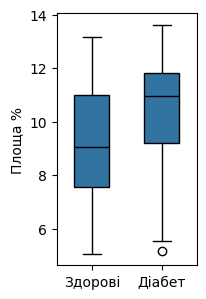

In [31]:
from scipy.stats import mannwhitneyu, ttest_ind

def make_boxplot(db, hl, column):
    plt.figure(figsize=(2, 3))

    u_statistic, p_value = ttest_ind(db[column], hl[column])
    # u_statistic, p_value = mannwhitneyu(db[column], hl[column])
    combined_data = pd.DataFrame({
    'Values': hl[column].tolist() + db[column].tolist(),
    'Group': ['Здорові'] * len(hl[column]) + ['Діабет'] * len(db[column])
    })
    
    sns.boxplot(x='Group', y='Values', data=combined_data, width=0.5, linewidth=1, linecolor='k')

    # if column == "alpha helix":
    #     plt.title(r"$\alpha$-спіраль")
    # elif column == "intermol beta sheet":
    #     plt.title(r"Інтермол. $\beta$-лист")

    plt.ylabel('Площа %')
    plt.xlabel("")
    print(column, p_value)

make_boxplot(db, hl, "alpha helix")
plt.subplots_adjust(top=0.95, left=0.2)
# plt.savefig("../figures/alpha_helix.pgf", transparent=True)

intermol beta sheet 1.022691678139887e-07


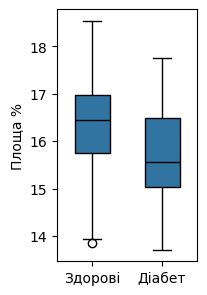

In [32]:
make_boxplot(db, hl, "intermol beta sheet")
plt.subplots_adjust(top=0.95, left=0.2)
# plt.savefig("../figures/intermol_beta.pgf", transparent=True)

beta turn 0.029114093898549534


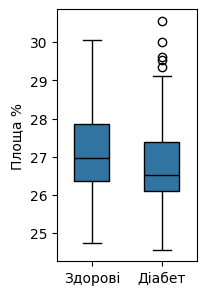

In [33]:
make_boxplot(db, hl, "beta turn")
plt.subplots_adjust(top=0.95, left=0.2)
# plt.savefig("../figures/intermol_beta.pgf", transparent=True)

In [34]:
hl['all beta'].mean()

68.84808629136442

In [35]:
db['all beta'].mean()

68.33787627060441

In [36]:
# def factors_plot(x_values, params, amplitude_df, n_components=20, factor=0):
#     """ Makes plot using parameters from pseudo voigt fitting """
#     y_peaks = []

#     fa = FactorAnalysis(n_components=n_components)
#     fa.fit(amplitude_df)
#     loadings_amplitude = fa.components_

#     plt.figure(figsize=(8, 3))
    
#     for index, row in params.iterrows():
#         wavenumber, gamma_gauss, gamma_lorentz, amplitude, eta = row[['wavenumber', 'gamma_gauss', 'gamma_lorentz', 'amplitude', 'eta']]
        
#         # amplitude = amplitude * loadings_amplitude[factor, index]
        
#         y_pred = combined_pseudo_voigt(x_values, wavenumber, gamma_gauss, gamma_lorentz, amplitude, eta)
#         y_pred = y_pred * loadings_amplitude[factor, index]
        
#         plt.plot(x_values, y_pred, color='k', linewidth=0.5, linestyle='--', alpha=0.8)
#         y_peaks.append(y_pred)
    
#     y_peaks = np.array(y_peaks)

#     plt.plot(x_values, y_peaks.sum(axis=0), color='k')
#     plt.xlim([min(x_values), max(x_values)])
#     plt.xlabel("Хвильове число")

# for i in range(10):
#     factors_plot(np.linspace(1000, 1730, 2000), params, 
#                  amplitude.drop(columns='HbA1c'), 
#                  n_components=100, factor=i)
#     plt.title(f"PC {i + 1}")

In [37]:
# path = "../data/fits/fit_1250_2750_w5_o3/"
# y_combined = []

# for file in os.listdir(path):
#     filename = os.path.splitext(file)[0]
#     params = pd.read_csv(os.path.join(path, file)).iloc[:, 1:]

#     x_values = X.iloc[:, 1250:2750].columns.to_numpy()
    
#     y_sample = np.zeros_like(x_values)
    
#     for index, row in params.iterrows():
#         wavenumber, gamma_gauss, gamma_lorentz, amplitude, eta = row[['wavenumber', 'gamma_gauss', 'gamma_lorentz', 'amplitude', 'eta']]
        
        
#         y_pred = combined_pseudo_voigt(x_values, wavenumber, gamma_gauss, gamma_lorentz, amplitude, eta)
        
#         # plt.plot(x_values, y_pred, color='k', linewidth=0.5, linestyle='--', alpha=0.8)
#         y_sample += y_pred
    
#     y_combined.append(y_sample)

# y_combined = np.array(y_combined)

In [38]:
wavenumbers_amide = pd.DataFrame(wavenumbers_amide, columns=amide_columns)
wavenumbers_amide['HbA1c'] = hba1c_amide

db_wn = wavenumbers_amide[wavenumbers_amide['HbA1c'] >= 6.5]
hl_wn = wavenumbers_amide[wavenumbers_amide['HbA1c'] < 6.5]

delta_amides = []

for column in db_wn.columns[:-1]:  # Exclude the 'HbA1c' column
    u_statistic, p_value = mannwhitneyu(db_wn[column], hl_wn[column])
    
    # Calculate mean values
    mean_db_wn = db_wn[column].mean()
    mean_hl_wn = hl_wn[column].mean()

    delta_amide = mean_db_wn - mean_hl_wn
    delta_amides.append(delta_amide)
    
    if p_value < 0.0001:
        print(f"{column} | p-value: {p_value:.5e} | Mean (>=6.5%): {mean_db_wn:.4f} | Mean (<6.5%): {mean_hl_wn:.4f} | delta: {delta_amide:.3f}")

np.mean(np.abs(delta_amides))

1600-1603 | p-value: 1.27437e-07 | Mean (>=6.5%): 1600.8287 | Mean (<6.5%): 1601.5306 | delta: -0.702
1611-1614 | p-value: 1.10872e-05 | Mean (>=6.5%): 1613.1180 | Mean (<6.5%): 1613.1708 | delta: -0.053
1622-1626 | p-value: 9.28470e-08 | Mean (>=6.5%): 1624.2180 | Mean (<6.5%): 1624.4157 | delta: -0.198
1643-1646 | p-value: 9.13481e-05 | Mean (>=6.5%): 1644.3931 | Mean (<6.5%): 1644.6380 | delta: -0.245
1646-1649 | p-value: 6.76267e-12 | Mean (>=6.5%): 1648.5522 | Mean (<6.5%): 1649.0687 | delta: -0.516
1655-1657 | p-value: 1.02565e-10 | Mean (>=6.5%): 1655.6886 | Mean (<6.5%): 1655.5244 | delta: 0.164
1659-1663 | p-value: 3.69868e-05 | Mean (>=6.5%): 1660.5295 | Mean (<6.5%): 1660.3510 | delta: 0.178
1672-1675 | p-value: 1.40254e-08 | Mean (>=6.5%): 1674.1887 | Mean (<6.5%): 1674.0131 | delta: 0.176
1681-1685 | p-value: 2.91151e-05 | Mean (>=6.5%): 1683.0670 | Mean (<6.5%): 1683.0224 | delta: 0.045
1686-1689 | p-value: 6.75304e-06 | Mean (>=6.5%): 1687.5259 | Mean (<6.5%): 1687.1571 

0.1935614463073125

In [39]:
# fwhms_amide = pd.DataFrame(fwhms_amide, columns=amide_columns)
# fwhms_amide['HbA1c'] = hba1c_amide

# db_fwhm = fwhms_amide[fwhms_amide['HbA1c'] >= 6.5]
# hl_fwhm = fwhms_amide[fwhms_amide['HbA1c'] < 6.5]

# for column in db_fwhm.columns[:-1]:  # Exclude the 'HbA1c' column
#     u_statistic, p_value = mannwhitneyu(db_fwhm[column], hl_fwhm[column])
    
#     # Calculate mean values
#     mean_db_fwhm = db_fwhm[column].mean()
#     mean_hl_fwhm = hl_fwhm[column].mean()

    
#     if p_value < 0.0001:
#         print(f"{column} | p-value: {p_value:.5e} | Mean (>=6.5%): {mean_db_fwhm:.4f} | Mean (<6.5%): {mean_hl_fwhm:.4f}")

#         combined_data = pd.DataFrame({
#         'Values': hl_fwhm[column].tolist() + db_fwhm[column].tolist(),
#         'Group': ['Здорові'] * len(hl_fwhm[column]) + ['Діабет'] * len(db_fwhm[column])
#         })

#         plt.figure(figsize=(2, 3))
#         plt.xlabel("")
#         plt.ylabel("FWHM")
#         plt.title(column)
#         sns.boxplot(x='Group', y='Values', data=combined_data, width=0.5, linewidth=1, linecolor='k')
#         plt.show()

In [40]:
# amplitude_amide = pd.DataFrame(amplitude_amide, columns=amide_columns)
# amplitude_amide['HbA1c'] = hba1c_amide

# db_amplitude = amplitude_amide[amplitude_amide['HbA1c'] >= 6.5]
# hl_amplitude = amplitude_amide[amplitude_amide['HbA1c'] < 6.5]

# for column in db_amplitude.columns[:-1]:  # Exclude the 'HbA1c' column
#     u_statistic, p_value = mannwhitneyu(db_amplitude[column], hl_amplitude[column])
    
#     # Calculate mean values
#     mean_db_amplitude = db_amplitude[column].mean()
#     mean_hl_amplitude = hl_amplitude[column].mean()

    
#     if p_value < 0.0001:
#         print(f"{column} | p-value: {p_value:.5e} | Mean (>=6.5%): {mean_db_amplitude:.4f} | Mean (<6.5%): {mean_hl_amplitude:.4f}")

#         combined_data = pd.DataFrame({
#         'Values': hl_amplitude[column].tolist() + db_amplitude[column].tolist(),
#         'Group': ['Здорові'] * len(hl_amplitude[column]) + ['Діабет'] * len(db_amplitude[column])
#         })

#         plt.figure(figsize=(2, 3))
#         plt.xlabel(" ")
#         plt.ylabel("Амплітуда")
#         plt.title(f"Пік: {column}")
#         sns.boxplot(x='Group', y='Values', data=combined_data, width=0.5, linewidth=1, linecolor='k')
#         plt.show()

In [41]:
areas

0,1012,1029,1047,1051,1080,1104,1126,1159,1169,1205,...,1667,1674,1678,1683,1687,1694,1699,1703,1717,HbA1c
0,3.004469e-02,0.423279,0.197035,0.692862,3.177947,1.543154,1.034312,1.794195,0.711925,1.066545,...,1.537812,0.859075,0.657366,0.417675,0.640951,0.484070,0.052214,0.186927,0.008792,7.50
1,2.380129e-02,0.180449,0.229111,0.827571,3.047309,1.238248,0.889987,1.562161,0.889252,1.260084,...,1.435668,0.921323,0.652447,0.443841,0.595029,0.465957,0.063114,0.200397,0.000251,5.62
2,6.800606e-03,0.137020,0.272199,0.644760,2.465733,1.501606,0.796812,1.434340,0.972602,0.988446,...,1.715575,1.064700,0.478134,0.271388,0.833557,0.422573,0.066703,0.191758,0.011265,5.00
3,2.117160e-02,0.386796,0.137272,0.637335,3.343420,1.461306,0.797160,1.813897,0.673213,1.123274,...,1.544887,0.901583,0.632961,0.420961,0.568082,0.481679,0.043299,0.257849,0.008773,5.52
4,2.672008e-02,0.345536,0.172601,0.633638,2.807190,1.355746,1.224292,1.582019,0.933277,0.722563,...,1.624721,0.896725,0.614288,0.541352,0.406042,0.593830,0.060876,0.091605,0.017099,7.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,7.720817e-07,0.259440,0.184921,0.646640,3.200198,1.210957,0.915665,1.344428,1.030137,0.816446,...,1.494968,0.896241,0.891569,0.287573,0.591306,0.479220,0.044069,0.142022,0.020472,4.72
290,4.017910e-02,0.194569,0.284148,0.712687,2.694521,1.815065,0.750962,1.941565,0.552010,1.053733,...,1.789534,0.832550,0.591616,0.415656,0.655895,0.656225,0.064937,0.224892,0.021508,5.55
291,3.359941e-02,0.190809,0.260523,0.728370,2.818493,1.483486,0.979344,1.875498,0.487479,1.032190,...,1.569232,1.019821,0.615544,0.233525,0.864965,0.365482,0.028076,0.242134,0.003450,5.17
292,3.071702e-02,0.228484,0.277947,0.683478,2.941092,1.252572,1.027853,1.395868,0.771856,1.303319,...,1.652257,1.002200,0.648921,0.229949,0.950463,0.298755,0.096310,0.279486,0.008843,5.20


In [42]:
varimp = pd.read_csv("varimp_areas.csv", index_col=0)
varimp = varimp.head(10)
varimp

,scaled_importance
1029,1.000000
1012,0.686240
1567,0.567197
1104,0.463336
1452,0.397960
1590,0.367076
1415,0.363553
1660,0.363237
1678,0.358994
1601,0.343183


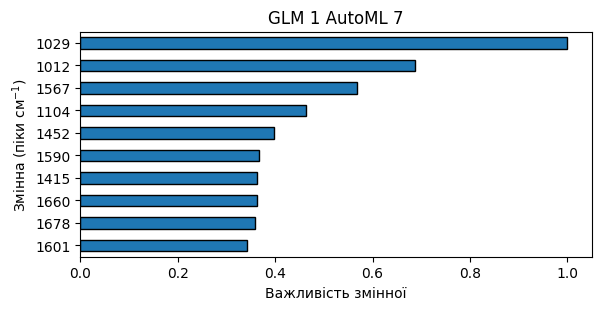

In [43]:
# plt.figure(figsize=(6.6, 3))
varimp.plot(kind='barh', edgecolor='k', legend=False, figsize=(6.6, 3))
plt.ylabel('Змінна (піки см$^{-1}$)')
plt.xlabel('Важливість змінної')
plt.title("GLM_1_AutoML_7".replace("_", " "))
plt.gca().invert_yaxis()
plt.subplots_adjust(bottom=0.13)
# plt.savefig("../figures/variable_importance.pgf")

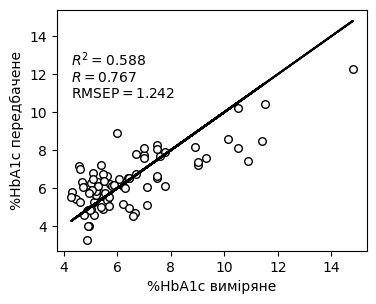

In [44]:
test, predicted = pd.read_csv("test_predict.csv").iloc[:, 1:].to_numpy().T
fig, axs = plsr_r2_plot(test, predicted)
fig.set_size_inches(4, 2.8)
axs.set_xlabel("%HbA1c виміряне")
axs.set_ylabel("%HbA1c передбачене")
plt.subplots_adjust(bottom=0.14, top=1)
# fig.savefig("../figures/h2o_predicted.pgf", transparent=True)

In [47]:
age.mean()

59.414965986394556

In [48]:
age.std()

16.596796485173627